# Demonstration notebook for DensityFieldTools

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DensityFieldTools import DensityField3D, PkX

In [2]:
BoxSize = 1000. #Mpc/h
kF = 2*np.pi/BoxSize #h/Mpc
grid = 256

## Load an example density field

In [3]:
field = DensityField3D(BoxSize,grid,n_threads=1,FFTW_WISDOM=False)
field.Load_r2c(np.load(f"df_m_256_PCS_z=0.npy"),MAS='PCS')

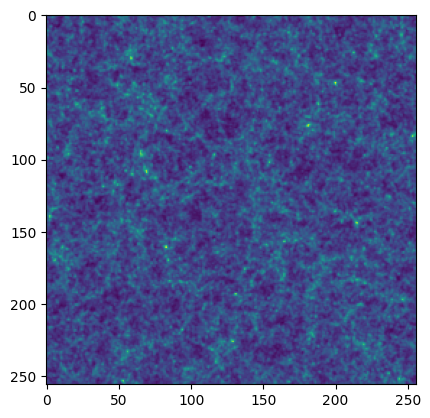

In [4]:
plt.imshow(field.r_delta.mean(2))
plt.show()

## Compute the power spectrum

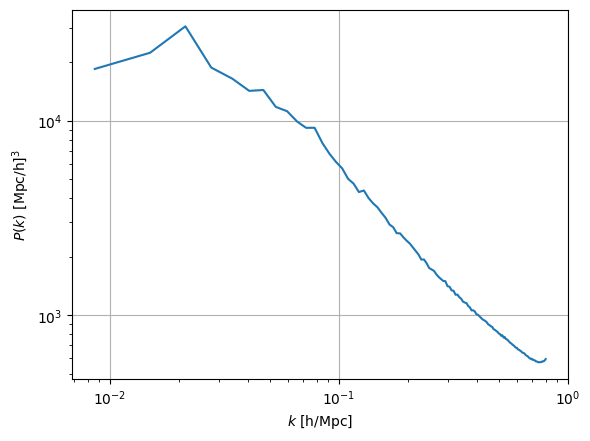

In [5]:
Pks = field.Pk()
plt.loglog(Pks[:,0],Pks[:,1])

plt.ylabel("$P(k)$ [Mpc/h]$^3$")
plt.xlabel("$k$ [h/Mpc]")
plt.grid()
plt.show()

## Compute the bispectrum for a desired binning

In [6]:
%time BBB = field.Bk(3,3,13,triangle_type='All',verbose=True)

Considering 294 Triangle Configurations (All)
Creating Grids for Counts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


Computing Powerspectrum Counts... 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.11it/s]


Computing Triangle Counts... 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:05<00:00, 55.72it/s]


Saved Triangle Counts to FFTest3D_BkCounts_LBox1000.0_Grid256_Binning3kF_fc3_NBins13_TriangleTypeAll.npy
Creating Grids for Measurements...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


Computing Powerspectrum... 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 68.29it/s]


Computing Bispectrum... 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:06<00:00, 47.36it/s]

CPU times: user 16.3 s, sys: 3.35 s, total: 19.7 s
Wall time: 19.7 s


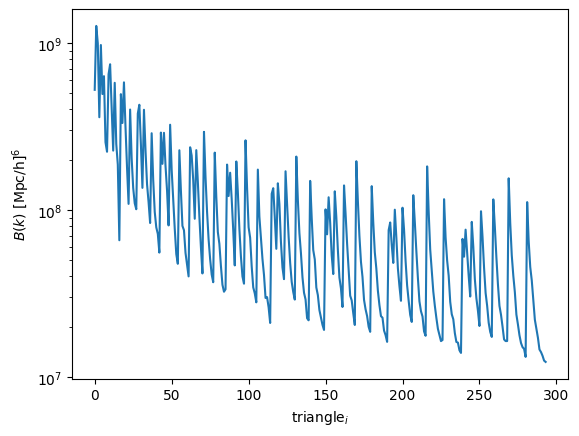

In [7]:
plt.semilogy(BBB[:,-2])
plt.ylabel("$B(k)$ [Mpc/h]$^6$")
plt.xlabel("triangle$_i$")
plt.show()

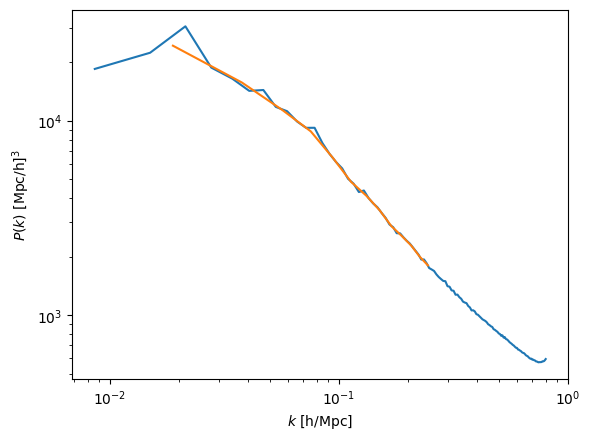

In [8]:
plt.loglog(Pks[:,0],Pks[:,1])
plt.loglog(np.unique(BBB[:,0])*kF,np.unique(BBB[:,3])[::-1])
plt.ylabel("$P(k)$ [Mpc/h]$^3$")
plt.xlabel("$k$ [h/Mpc]")
plt.show()

## We also provide a quick way to measure (cross-)power spectra directly from density fields

CPU times: user 773 ms, sys: 64.9 ms, total: 838 ms
Wall time: 837 ms
CPU times: user 1.73 s, sys: 101 ms, total: 1.83 s
Wall time: 1.83 s


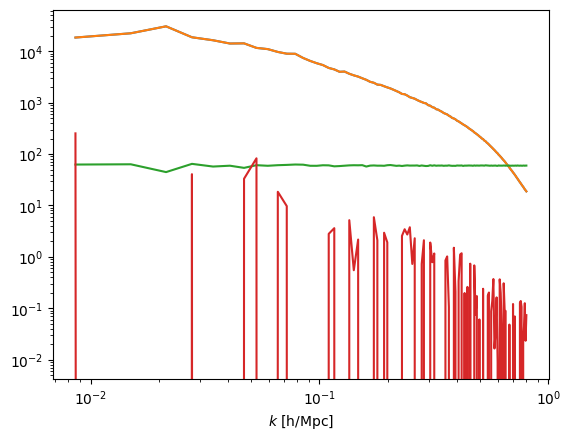

In [9]:
%time Pself = PkX(field.r_delta,1000,)
%time Pcross = PkX(field.r_delta,1000,np.random.normal(0,1,field.r_delta.shape))

plt.loglog(Pself[:,0],Pself[:,1])
plt.loglog(Pcross[:,0],Pcross[:,1])
plt.loglog(Pcross[:,0],Pcross[:,2])
plt.loglog(Pcross[:,0],Pcross[:,3])
plt.xlabel("$k$ [h/Mpc]")
plt.show()